Jest to projekt NLP, w którym stworzę system zdolny do rozpoznawania emocji z koła emocji Plutchika i odpowiadających im odczuć przekazywanych w recenzjach konsumenckich. Szczegóły zadania i zbiory danych są dostępne tutaj: https://github.com/poleval/2024-emotion-recognition.

**Autor:** Julia Poteralska

---

# Import danych

**Instalacja narzędzi i import bibliotek**

In [2]:
!pip install -q transformers[torch] datasets
!pip install -q wandb
!pip install accelerate -U
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 68.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests

In [3]:
!wandb login
import wandb
import numpy as np
import pandas as pd
import evaluate
import io

from sklearn.model_selection import train_test_split
from google.colab import files
from datasets import load_dataset, DatasetDict, Dataset, load_metric
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


**Wczytanie zbioru danych - train**

In [4]:
uploaded = files.upload()

Saving in.tsv to in.tsv


In [5]:
ds_in = pd.read_csv('in.tsv', sep='\t', header=0)

In [6]:
print(ds_in.head())

                                                text
0                                        2 gwiazdki.
1           Na tyle maksymalnie zasługuje ten hotel.
2  To, ze hotel ma 4 gwiazdki w nazwie jest żałosne.
3  Śmiesznie było już podczas rezerwacji, pani z ...
4  Udało mi się jednak dowiedzieć, ze w hotelu są...


In [7]:
ds_reviews_sentences = ds_in.drop(ds_in[ds_in['text'] == "###########################"].index) # usuwam przerywniki dzielące całe opinie

In [8]:
with open('in.tsv', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Przetwarzanie linii, aby stworzyć z nich tekst z całymi opiniami
merged_reviews = []
current_review = []

for line in lines:
    stripped_line = line.strip()
    if stripped_line == '###########################':
        if current_review:
            merged_reviews.append(' '.join(current_review))
            current_review = []
    else:
        current_review.append(stripped_line)

if current_review:
    merged_reviews.append(' '.join(current_review))

# Usuń nagłówek "text" z pierwszego rekordu, jeśli występuje
if merged_reviews[0].startswith('text'):
    merged_reviews[0] = merged_reviews[0][len('text '):]

# Tworzenie ramki danych z połączonych opinii
ds_reviews = pd.DataFrame({'text': merged_reviews})

print(ds_reviews.head())

                                                text
0  2 gwiazdki. Na tyle maksymalnie zasługuje ten ...
1  "RADPOL S.A. z siedzibą w Człuchowie (""Spółka...
2  Od 6 marca br. Gromadą kieruje Zarząd w składz...
3  Statyw zwraca na siebie uwagę naprawdę mikrosk...
4  Kurs: chemia ogólna - wykład koleś dziwny nie ...


In [9]:
uploaded = files.upload() # to samo powtarzam dla zbioru z oczekiwanymi wartościami (dzielę na wartości dla poszczególnych zdań i całych opinii)

Saving expected.tsv to expected.tsv


In [10]:
ds_expected = pd.read_csv('expected.tsv', sep='\t', header=0)

In [11]:
print(ds_expected.head())

     Joy  Trust  Anticipation  Surprise   Fear  Sadness  Disgust  Anger  \
0  False  False         False      True  False     True    False   True   
1  False  False         False     False  False     True     True   True   
2  False  False         False     False  False    False     True   True   
3  False  False         False     False  False     True     True   True   
4   True  False         False     False  False    False    False   True   

   Positive  Negative  Neutral  
0     False      True    False  
1     False      True    False  
2     False      True    False  
3     False      True    False  
4     False      True     True  


In [12]:
ds_emotions_sentences = ds_expected.drop(ds_in[ds_in['text'] == "###########################"].index)

In [13]:
ds_emotions = ds_expected.loc[ds_in[ds_in['text'] == "###########################"].index]
print(ds_emotions.head())

      Joy  Trust  Anticipation  Surprise   Fear  Sadness  Disgust  Anger  \
47  False  False         False      True  False     True     True   True   
56  False  False         False     False  False    False    False  False   
61  False  False         False     False  False    False    False  False   
67   True  False         False     False  False     True    False  False   
73   True   True         False     False  False    False    False  False   

    Positive  Negative  Neutral  
47     False      True    False  
56     False     False     True  
61      True     False     True  
67      True      True    False  
73      True     False    False  


**Wczytanie zbioru danych - test**

In [14]:
uploaded = files.upload()

Saving in_testB.tsv to in_testB.tsv
Saving in_testA.tsv to in_testA.tsv


In [15]:
testA = pd.read_csv('in_testA.tsv', sep='\t', header=0)

In [16]:
testB = pd.read_csv('in_testB.tsv', sep='\t', header=0)

In [17]:
print(testA.head())

                                                text
0             Miałem kontakt z seksuologiem mailowy.
1  Wyczytałem na stronie seksuolog.org.pl, że moż...
2  Po trzech dniach otrzymałem wyjasnienie niepok...
3  Było to za jedną opłatom ale nie dla lekarza, ...
4  Trzeba było SAMEMU wpłacić i przysłać dowod le...


In [18]:
print(testB.head())

                                                text
0    Przez 12 lat leczyła mnie ze złym rozpoznaniem.
1  Teraz jestem leczony na prawidłową chorobę, bi...
2  Poza tym każda wizyta, nawet po 10 latach lecz...
3  Na dodatek pani doktor nie raczyła poinformowa...
4                        ###########################


In [19]:
ds_testA_sentences = testA.drop(testA[testA['text'] == "###########################"].index) # usuwam przerywniki dzielące całe opinie

In [20]:
ds_testB_sentences = testB.drop(testB[testB['text'] == "###########################"].index)

In [21]:
print(ds_testB_sentences.head())

                                                text
0    Przez 12 lat leczyła mnie ze złym rozpoznaniem.
1  Teraz jestem leczony na prawidłową chorobę, bi...
2  Poza tym każda wizyta, nawet po 10 latach lecz...
3  Na dodatek pani doktor nie raczyła poinformowa...
5                                        OSTRZEGAM!!


In [22]:
with open('in_testA.tsv', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Przetwarzanie linii, aby stworzyć z nich tekst z całymi opiniami
merged_reviews = []
current_review = []

for line in lines:
    stripped_line = line.strip()
    if stripped_line == '###########################':
        if current_review:
            merged_reviews.append(' '.join(current_review))
            current_review = []
    else:
        current_review.append(stripped_line)

if current_review:
    merged_reviews.append(' '.join(current_review))

# Usuń nagłówek "text" z pierwszego rekordu, jeśli występuje
if merged_reviews[0].startswith('text'):
    merged_reviews[0] = merged_reviews[0][len('text '):]

# Tworzenie ramki danych z połączonych opinii
ds_testA = pd.DataFrame({'text': merged_reviews})

print(ds_testA.head())

                                                text
0  Miałem kontakt z seksuologiem mailowy. Wyczyta...
1  Hotel fantastycznie położony, tuż nad samym je...
2  Hotel położony nieopodal Koszalina. Pokoje śre...
3  Pragnę serdecznie podziękować Panu dr Marcinow...
4  Pani Profesor jest lekarzem wybitnym, specjali...


In [23]:
with open('in_testB.tsv', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Przetwarzanie linii, aby stworzyć z nich tekst z całymi opiniami
merged_reviews = []
current_review = []

for line in lines:
    stripped_line = line.strip()
    if stripped_line == '###########################':
        if current_review:
            merged_reviews.append(' '.join(current_review))
            current_review = []
    else:
        current_review.append(stripped_line)

if current_review:
    merged_reviews.append(' '.join(current_review))

# Usuń nagłówek "text" z pierwszego rekordu, jeśli występuje
if merged_reviews[0].startswith('text'):
    merged_reviews[0] = merged_reviews[0][len('text '):]

# Tworzenie ramki danych z połączonych opinii
ds_testB = pd.DataFrame({'text': merged_reviews})

print(ds_testB.head())

                                                text
0  Przez 12 lat leczyła mnie ze złym rozpoznaniem...
1  OSTRZEGAM!! Organizowałam w hotelu imprezę uro...
2  But zewnętrznie robi piorunujące wrażenie. Pod...
3  Jestem zawiedziona operacją wykonaną przez lek...
4  Jestem pacjętką doktora od 3 lat i naprawdę je...


# Eksploracja zbiorów danych

In [24]:
# sprawdzam czy długości zbiorów są poprawne
print(len(ds_reviews))
print(len(ds_emotions))
print(len(ds_reviews_sentences))
print(len(ds_emotions_sentences))

print(len(ds_testA))
print(len(ds_testB))
print(len(ds_testA_sentences))
print(len(ds_testB_sentences))

776
776
6393
6393
167
167
1234
1264


In [25]:
# sprawdzenie ewentualnych braków w danych
print(np.where(pd.isnull(ds_emotions)))
print(np.where(pd.isnull(ds_reviews)))
print(np.where(pd.isnull(ds_reviews_sentences)))
print(np.where(pd.isnull(ds_emotions_sentences)))

print(np.where(pd.isnull(ds_testA)))
print(np.where(pd.isnull(ds_testB)))
print(np.where(pd.isnull(ds_testA_sentences)))
print(np.where(pd.isnull(ds_testB_sentences)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [26]:
# sprawdzenie pustych stringów
print(np.where(ds_reviews.applymap(lambda x: x == '')))
print(np.where(ds_reviews_sentences.applymap(lambda x: x == '')))
print(np.where(ds_emotions.applymap(lambda x: x == '')))
print(np.where(ds_emotions_sentences.applymap(lambda x: x == '')))

print(np.where(ds_testA.applymap(lambda x: x == '')))
print(np.where(ds_testA_sentences.applymap(lambda x: x == '')))
print(np.where(ds_testB.applymap(lambda x: x == '')))
print(np.where(ds_testB_sentences.applymap(lambda x: x == '')))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


# Model dla całych zdań

**Przygotowanie danych do przetwarzania przez transformery**

In [27]:
dataset = []
for index, row in ds_reviews.iterrows():
    text = row['text']
    # tylko te etykiety, które mają wartość True
    label = [1 if value else 0 for emotion, value in ds_emotions.iloc[index].items()]
    dataset.append({'text': text, 'label': label})

train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))
val_dataset = Dataset.from_pandas(pd.DataFrame(val_data))

In [28]:
testA_dataset = Dataset.from_pandas(pd.DataFrame(ds_testA))
testB_dataset = Dataset.from_pandas(pd.DataFrame(ds_testB))

In [29]:
final_dataset = DatasetDict({
    "train": train_dataset,
    "valid": val_dataset,
    "testA": testA_dataset,
    "testB": testB_dataset
})

# Przykład:
example_index = 0
print(final_dataset["train"][example_index])

{'text': 'Hotel odpowiedni na każde warunki pogodowe. 5 minut spacerkiem przez las do plaży, a po plaży duży ogród, mini zoo i rowery. Na niepogodę basen ze zjeżdżalnią, Playland, kluby i dyskoteki. Do tego fantastyczne animacje dla dzieci. Pokoje nie za wielkie i niezbyt bogato wyposażone, ale ciepłe, czyste i schludne. Brak mebli balkonowych i palarni. Najlepsza jest kuchnia. Przy pakiecie z 3 posiłkami można przybrać szybko kilka kilogramów. Jedzenie smaczne, każdy posiłek dostosowany do ludzi dbających o dietę, lubiących pojeść oraz dla dzieciaczków. Obsługa, mimo natłoku radzi sobie sprawnie, wszystko uzupełniane na bieżąco, do każdego z posiłków ze stołem szwedzkim.', 'label': [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]}


In [30]:
print(final_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 620
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 156
    })
    testA: Dataset({
        features: ['text'],
        num_rows: 167
    })
    testB: Dataset({
        features: ['text'],
        num_rows: 167
    })
})


**Dotrenowanie modelu typu BERT**

In [31]:
max_length = 512
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=max_length)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [32]:
tokenized_datasets = final_dataset.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/620 [00:00<?, ? examples/s]

Map:   0%|          | 0/156 [00:00<?, ? examples/s]

Map:   0%|          | 0/167 [00:00<?, ? examples/s]

Map:   0%|          | 0/167 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 620
    })
    valid: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 156
    })
    testA: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 167
    })
    testB: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 167
    })
})

# Model dla pojedyńczych zdań

**Przygotowanie danych do przetwarzania przez transformery**

In [33]:
dataset2 = []
for index, row in ds_reviews_sentences.iterrows():
    if index < len(ds_emotions_sentences): # sprawdzam, czy index jest w granicach
        text = row['text']
        # tylko te etykiety, które mają wartość True
        label = [1 if value else 0 for emotion, value in ds_emotions_sentences.iloc[index].items()]
        dataset2.append({'text': text, 'label': label})

train_data2, val_data2 = train_test_split(dataset2, test_size=0.2, random_state=42)
train_dataset2 = Dataset.from_pandas(pd.DataFrame(train_data2))
val_dataset2 = Dataset.from_pandas(pd.DataFrame(val_data2))

In [34]:
testA_dataset2 = Dataset.from_pandas(pd.DataFrame(ds_testA_sentences))
testB_dataset2 = Dataset.from_pandas(pd.DataFrame(ds_testB_sentences))

In [35]:
final_dataset2 = DatasetDict({
    "train": train_dataset2,
    "valid": val_dataset2,
    "testA": testA_dataset2,
    "testB": testB_dataset2
})

# Przykład:
example_index = 2
print(final_dataset2["train"][example_index])

{'text': 'Blisko metro (20 minut do Luwru), piekarnia, sklepiki.', 'label': [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]}


**Dotrenowanie modelu typu BERT**

In [36]:
max_length = 512
tokenizer2 = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function2(examples):
    return tokenizer2(examples["text"], padding="max_length", truncation=True, max_length=max_length)


In [37]:
tokenized_datasets2 = final_dataset2.map(tokenize_function, batched=True)
tokenized_datasets2

Map:   0%|          | 0/4544 [00:00<?, ? examples/s]

Map:   0%|          | 0/1136 [00:00<?, ? examples/s]

Map:   0%|          | 0/1234 [00:00<?, ? examples/s]

Map:   0%|          | 0/1264 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4544
    })
    valid: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1136
    })
    testA: Dataset({
        features: ['text', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1234
    })
    testB: Dataset({
        features: ['text', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1264
    })
})

# Trening i ewaluacja

**Trening z budowaną klasą Trainer**

In [38]:
#data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='max_length')
#data_collator2 = DataCollatorWithPadding(tokenizer=tokenizer2, padding='max_length')

In [39]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=11)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
f1 = load_metric("f1", trust_remote_code=True)

In [41]:
# Metoda do liczenia macro F1 score:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    if labels is None or len(labels) == 0:
        print("Labels are None or empty.")
        return {"f1": 0.0}
    labels = labels.flatten().astype(int) if labels is not None else np.array([])
    f1_results = f1.compute(predictions=predictions, references=labels, average='macro')
    macro_f1 = f1_results['f1']
    return {"f1": macro_f1}

In [42]:
training_args = TrainingArguments(output_dir="test_trainer",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=2,
                                  learning_rate=0.0002,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  weight_decay=0.001,
                                  disable_tqdm=False,
                                  overwrite_output_dir=True,
                                  metric_for_best_model='eval_loss',
                                  load_best_model_at_end=True,
                                  save_strategy='epoch',
                                  logging_strategy='epoch',
                                  log_level='error',
                                  warmup_ratio=0.05,
                                  report_to='wandb')

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [47]:
# Trainer dla całych tekstów
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['valid'],
)

In [48]:
# Trainer dla pojedyńczych zdań
trainer2 = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets2['train'],
    eval_dataset=tokenized_datasets2['valid'],
)

In [ ]:
wandb_initialized = False
try: # jeśli inicjalizacja się nie powiedzie, skrypt nie przerywa działania, a jedynie pomija logowanie do wandb
    wandb.init(project='sentiment_recognition', settings=wandb.Settings(start_method="fork"))
    wandb_initialized = True
except wandb.errors.CommError as e:
    print(f"Error przy inicjalizacji WandB: {e}")
#wandb.init(project='sentiment_recognition')

trainer.train()
trainer2.train()

preds_outputA = trainer.predict(tokenized_datasets['testA'])
preds_outputA2 = trainer2.predict(tokenized_datasets2['testA'])
preds_outputB = trainer.predict(tokenized_datasets['testB'])
preds_outputB2 = trainer2.predict(tokenized_datasets2['testB'])

# F1 macro dla pojedyńczych zdań
f1_macro_sentences_trainer1 = compute_metrics((preds_outputA2.predictions, preds_outputA2.label_ids))["f1"]
f1_macro_sentences_trainer2 = compute_metrics((preds_outputB2.predictions, preds_outputB2.label_ids))["f1"]
f1_macro_sentences = (f1_macro_sentences_trainer1 + f1_macro_sentences_trainer2) / 2

# F1 macro dla całych tekstów
f1_macro_texts_trainer1 = compute_metrics((preds_outputA.predictions, preds_outputA.label_ids))["f1"]
f1_macro_texts_trainer2 = compute_metrics((preds_outputB.predictions, preds_outputB.label_ids))["f1"]
f1_macro_texts = (f1_macro_texts_trainer1 + f1_macro_texts_trainer2) / 2

final_score = (f1_macro_sentences + f1_macro_texts) / 2
print(f"Final score: {final_score*100}%")
wandb_di = {'final_f1_macro': final_score}
if wandb_initialized:
    wandb.log(wandb_di)
    wandb.finish()
else:
    print("Pominięto rejestrowanie WandB z powodu błędu inicjalizacji.")

Epoch,Training Loss,Validation Loss
1,0.512900,0.496040
2,0.513500,0.491235


Epoch,Training Loss,Validation Loss
1,0.512900,0.505261
2,0.509900,0.504011


Labels are None or empty.
Labels are None or empty.
Labels are None or empty.
Labels are None or empty.
Final score: 0.0%


# Wykresy wandb

**Przeszkody:**

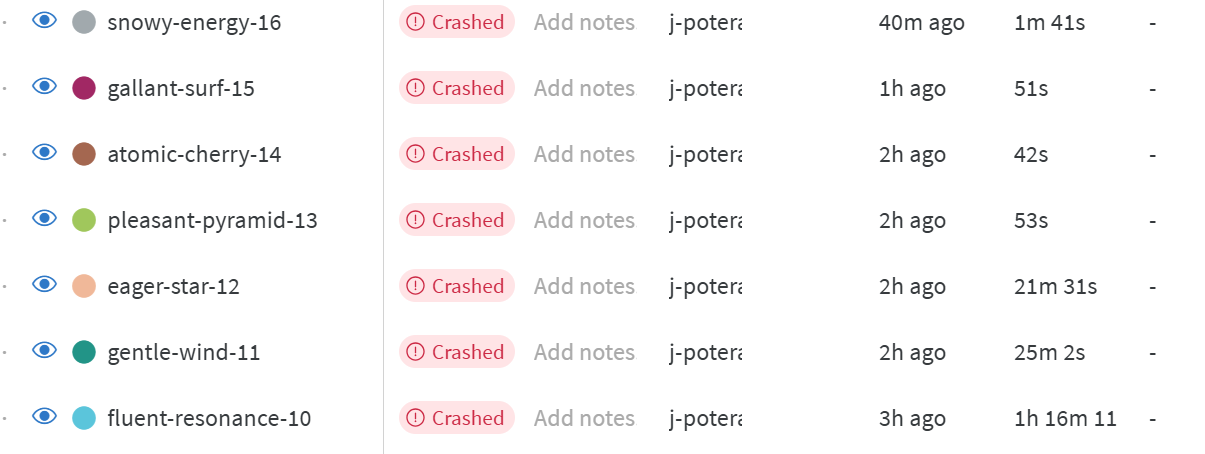

**Ewaluacja danych**

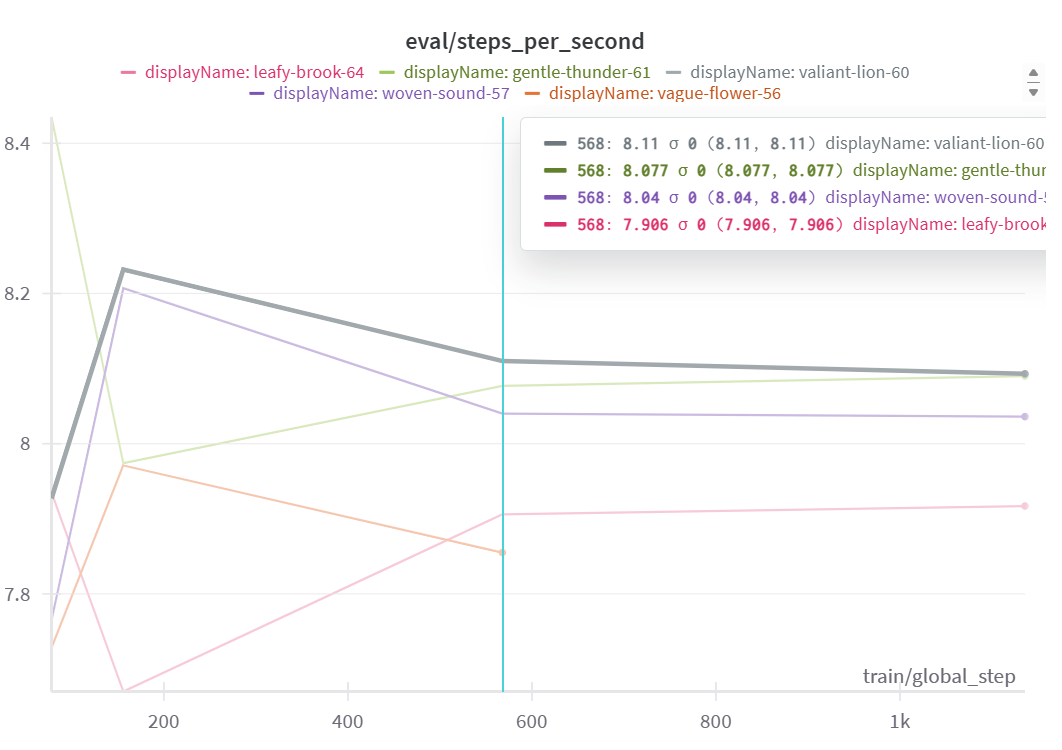

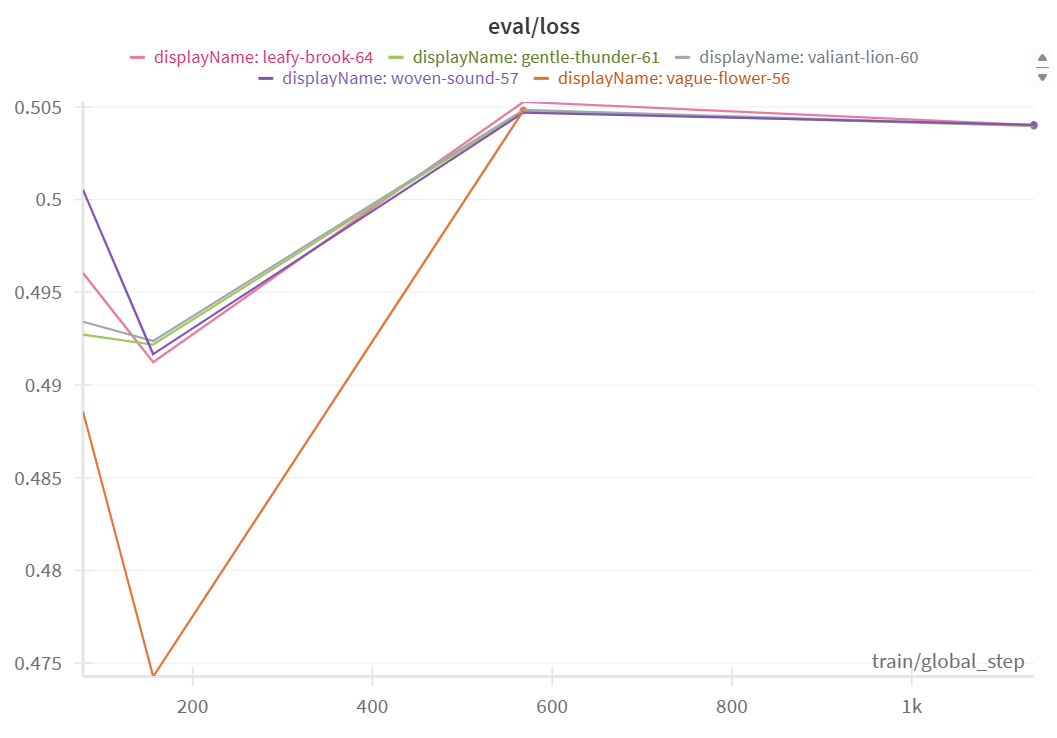

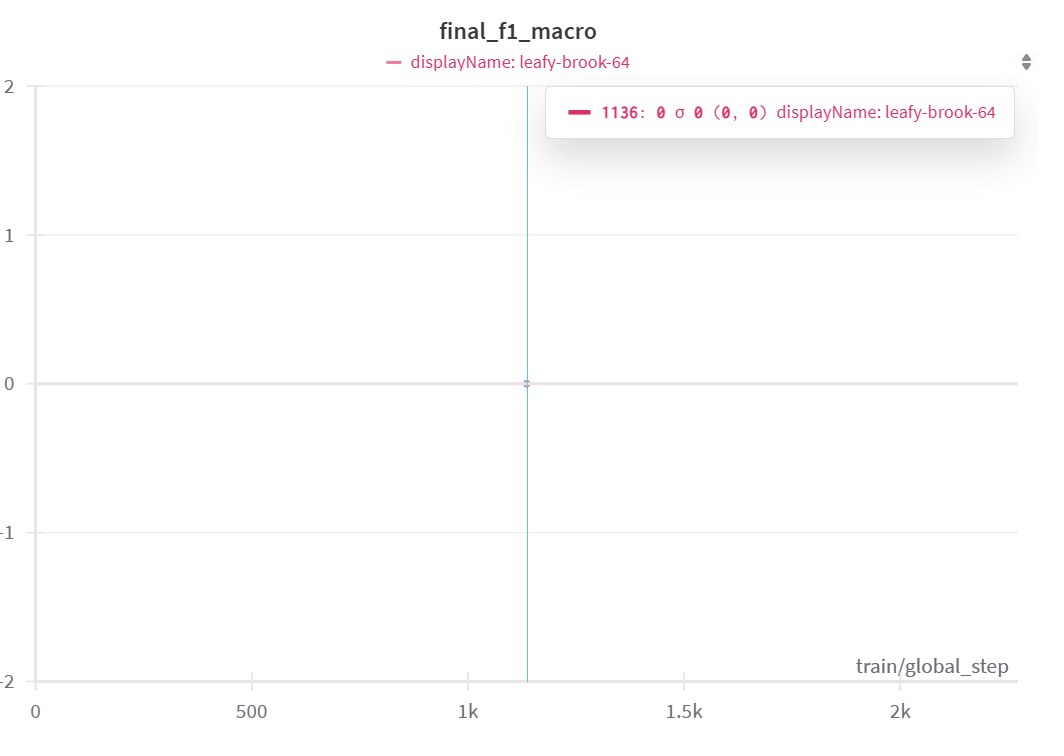

Final F1 macro dla jednego przebiegu. Dla różnych parametrów otrzymamy wiele różnych punktów, co pozwoli na ocenienie, dla których parametrów model najlepiej działa.